In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Clear any unused variables


In [75]:
import gc

gc.collect()

torch.cuda.empty_cache()

# Install Dependencies( Run this section before proceeding to detection or classification training or inference)

In [76]:
%%shell
pip install xmltodict
pip install torchmetrics
pip install timm
pip install efficientnet_pytorch
pip install pycocotools
pip install albumentations

In [77]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [78]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


### Imports


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensor
from torchmetrics import F1
from efficientnet_pytorch import EfficientNet

import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [80]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import os
from shutil import copyfile
import xmltodict
import json
from IPython.core.debugger import set_trace

## Head Annotations Preprocessing

In [81]:
def str2float2int(s):
  return int(float(s))

In [82]:
def get_image_annotations_dict(path):
    """Return the dictionary of image annotations read from xml file(Pascal Format)"""
    with open(path) as xml_file:

        data_dict = xmltodict.parse(xml_file.read())
        xml_file.close()
        json_data = json.dumps(data_dict)

    json_data = json.loads(json_data)
    json_data["annotations"]["image"][0]["box"][0]["attribute"]

    image_annotation_dict = dict([(i["@id"],i) for i  in json_data["annotations"]["image"]])
    print(len(image_annotation_dict.keys()))
    return image_annotation_dict


path = "drive/MyDrive/interview/task2/dataset/annotations.xml"
image_annotation_dict = get_image_annotations_dict(path)

img_dir = "/content/drive/MyDrive/interview/task2/dataset/images/"
image_files = os.listdir(img_dir)

train_images = []
val_images = []
test_images = []
for image in image_files:
  if image.split(".")[0] in image_annotation_dict.keys():
    train_images.append(image)
  else:
    test_images.append(image)

val_images = train_images[int(len(train_images) * 0.8): ]
train_images = train_images[ :int(len(train_images) * 0.8)]
len(train_images), len(val_images), len(test_images)
root_dir = "drive/MyDrive/interview/task2/dataset/"
img_dir = root_dir+"images"
# os.mkdir(root_dir+"train")
# os.mkdir(root_dir+"val")
# os.mkdir(root_dir+"test")
# for i in train_images:
#   copyfile(os.path.join(img_dir,i), os.path.join(root_dir+"train",i))
# for i in val_images:
#   copyfile(os.path.join(img_dir,i), os.path.join(root_dir+"val",i))
# for i in test_images:
#   copyfile(os.path.join(img_dir,i), os.path.join(root_dir+"test",i))


527


## Custom dataset for head detection

In [83]:
len(os.listdir(root_dir+"train")), len(os.listdir(root_dir+"val")), len(os.listdir(root_dir+"test")), 

(421, 106, 64)

In [84]:
image_annotation_dict["0"]

{'@height': '940',
 '@id': '0',
 '@name': '-the-company-to-ensure-the-production-at-full-capacity-amid-epidemic-prevention-and-control-efforts-credit-zhou-liangxinhuaalamy-live-news-2B1A2YF.jpg',
 '@width': '1300',
 'box': [{'@label': 'head',
   '@occluded': '0',
   '@xbr': '471.30',
   '@xtl': '331.37',
   '@ybr': '282.70',
   '@ytl': '117.98',
   'attribute': [{'#text': 'yes', '@name': 'has_safety_helmet'},
    {'#text': 'yes', '@name': 'mask'}]},
  {'@label': 'clothing',
   '@occluded': '0',
   '@xbr': '1288.16',
   '@xtl': '1016.74',
   '@ybr': '533.67',
   '@ytl': '238.20',
   'attribute': {'#text': 'false', '@name': 'is_safety_jacket'}},
  {'@label': 'clothing',
   '@occluded': '0',
   '@xbr': '612.59',
   '@xtl': '278.06',
   '@ybr': '592.02',
   '@ytl': '237.00',
   'attribute': {'#text': 'false', '@name': 'is_safety_jacket'}},
  {'@label': 'hand',
   '@occluded': '0',
   '@xbr': '621.49',
   '@xtl': '564.37',
   '@ybr': '342.35',
   '@ytl': '275.15'},
  {'@label': 'head',
   '

In [85]:
from detectron2.structures import BoxMode
def get_head_annotations(anno):
  # print(anno)
        
  obj = {
      "bbox": list(map(str2float2int,[anno["@xtl"],anno["@ytl"],anno["@xbr"],anno["@ybr"]])),
      "bbox_mode": BoxMode.XYXY_ABS,
      # "segmentation": [poly],
      "category_id": 0,
  }
  return obj

def get_head_dicts(img_dir, image_annotation_dict):
    img_list = os.listdir(img_dir)
    dataset_dicts = []
    for idx, v in enumerate(img_list):
      record = {}
      
      filename = os.path.join(img_dir, v)
      fileid = v.split(".")[0]
      # height, width = cv2.imread(filename).shape[:2]
      height, width = image_annotation_dict[fileid]["@height"],image_annotation_dict[fileid]["@width"]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = int(height)
      record["width"] = int(width)

      annos = image_annotation_dict[fileid]["box"]
      objs = []
      # print(v)
      if type(annos) == dict:
        if annos["@label"] == "head":
          objs.append(get_head_annotations(annos))
      else:
        for anno in annos:
          if anno["@label"] == "head":
            objs.append(get_head_annotations(anno))
      record["annotations"] = objs
      dataset_dicts.append(record)
    return dataset_dicts



In [86]:
for d in ["train", "val"]:
    DatasetCatalog.register("head_" + d, lambda d=d: get_head_dicts(root_dir + d,image_annotation_dict))
    MetadataCatalog.get("head_" + d).set(thing_classes=["head"])
head_metadata = MetadataCatalog.get("head_train")

AssertionError: ignored

In [87]:
type(image_annotation_dict["61"])

dict

In [88]:
dataset_dicts = get_head_dicts(root_dir+"train", image_annotation_dict)
dataset_dicts[0]

{'annotations': [{'bbox': [331, 117, 471, 282],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [1079, 112, 1209, 263],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': 'drive/MyDrive/interview/task2/dataset/train/0.jpg',
 'height': 940,
 'image_id': 0,
 'width': 1300}

## Configuration for detectron train and inference

In [89]:
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("head_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (head). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = "drive/MyDrive/interview/task2/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Head Detection Training

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [13]:
!nvidia-smi

Tue Apr 27 07:02:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
del trainer

In [14]:
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/27 08:09:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:04, 39.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[04/27 08:09:22 d2.engine.train_loop]: Starting training from iteration 0
[04/27 08:10:23 d2.utils.events]:  eta: 0:12:03  iter: 19  total_loss: 1.406  loss_cls: 0.6498  loss_box_reg: 0.5799  loss_rpn_cls: 0.1158  loss_rpn_loc: 0.03411  time: 3.0727  data_time: 1.1490  lr: 1.9981e-05  max_mem: 9422M
[04/27 08:11:14 d2.utils.events]:  eta: 0:10:57  iter: 39  total_loss: 1.37  loss_cls: 0.5932  loss_box_reg: 0.6526  loss_rpn_cls: 0.09746  loss_rpn_loc: 0.02342  time: 2.7981  data_time: 0.6041  lr: 3.9961e-05  max_mem: 9422M
[04/27 08:12:03 d2.utils.events]:  eta: 0:10:07  iter: 59  total_loss: 1.333  loss_cls: 0.5243  loss_box_reg: 0.6933  loss_rpn_cls: 0.08836  loss_rpn_loc: 0.03272  time: 2.6731  data_time: 0.3957  lr: 5.9941e-05  max_mem: 9422M
[04/27 08:12:45 d2.utils.events]:  eta: 0:08:55  iter: 79  total_loss: 1.317  loss_cls: 0.4643  loss_box_reg: 0.7354  loss_rpn_cls: 0.07341  loss_rpn_loc: 0.02968  time: 2.5255  data_time: 0.0968  lr: 7.9921e-05  max_mem: 9422M
[04/27 08:13:27 

In [15]:
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 500

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/27 08:20:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
cfg.SOLVER.BASE_LR = 0.1  # pick a good LR
cfg.SOLVER.MAX_ITER = 700

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/27 08:27:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [19]:
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/27 08:38:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [18]:
import torch
torch.cuda.empty_cache()

In [16]:
%load_ext tensorboard

In [ ]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [57]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES

1

In [24]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
predictor.model

Then, we randomly select several samples to visualize the prediction results.

{'instances': Instances(num_instances=1, image_height=150, image_width=300, fields=[pred_boxes: Boxes(tensor([[ 56.8115,   3.8754, 104.5899,  62.5473]], device='cuda:0')), scores: tensor([0.9972], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


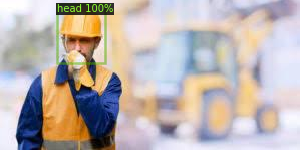

{'instances': Instances(num_instances=3, image_height=168, image_width=300, fields=[pred_boxes: Boxes(tensor([[179.8551,  31.0431, 229.1064,  94.6010],
        [114.5414,   6.4487, 197.5936,  91.8567],
        [ 61.6720,  43.1648, 122.8611, 110.6936]], device='cuda:0')), scores: tensor([0.9927, 0.9913, 0.9908], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


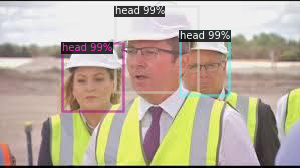

{'instances': Instances(num_instances=3, image_height=174, image_width=290, fields=[pred_boxes: Boxes(tensor([[199.2309,  16.1878, 247.8536,  69.4692],
        [132.3560,  41.6004, 176.0129,  93.5885],
        [ 51.8438,   1.5870,  98.1722,  55.8151]], device='cuda:0')), scores: tensor([0.9982, 0.9973, 0.9970], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


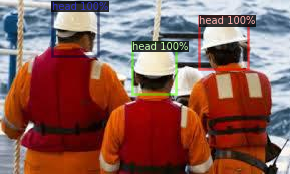

{'instances': Instances(num_instances=7, image_height=168, image_width=300, fields=[pred_boxes: Boxes(tensor([[196.0986,  25.9349, 210.8966,  44.8513],
        [199.6605,  51.2057, 214.2039,  67.4158],
        [ 80.9132,  52.3611,  95.6073,  65.7114],
        [106.2139,  63.7067, 121.0375,  82.3400],
        [138.1989,   5.8837, 152.2813,  22.8324],
        [ 78.3562,  19.8584,  89.8328,  33.1702],
        [126.5241,  39.1999, 137.9852,  50.8570]], device='cuda:0')), scores: tensor([0.9748, 0.9687, 0.9643, 0.9372, 0.9048, 0.8713, 0.7677],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')])}


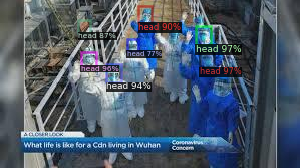

{'instances': Instances(num_instances=2, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[193.2645,  45.1651, 205.3948,  62.2464],
        [ 64.4283,  46.2114,  80.4507,  66.4062]], device='cuda:0')), scores: tensor([0.9926, 0.9920], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


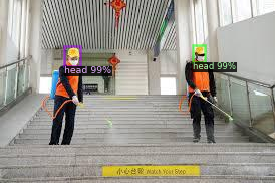

{'instances': Instances(num_instances=3, image_height=167, image_width=301, fields=[pred_boxes: Boxes(tensor([[ 60.2727,  66.3224,  82.3014,  95.1499],
        [249.7544,  63.5545, 270.6750,  90.7875],
        [212.8373,  57.1579, 230.4670,  76.2271]], device='cuda:0')), scores: tensor([0.9967, 0.9963, 0.9835], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}


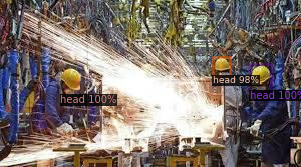

{'instances': Instances(num_instances=5, image_height=174, image_width=290, fields=[pred_boxes: Boxes(tensor([[4.8048e+01, 6.9350e+01, 7.6271e+01, 1.0260e+02],
        [1.2195e+02, 1.2253e+01, 1.2596e+02, 1.6931e+01],
        [2.6757e+02, 1.1719e-01, 2.8655e+02, 1.8473e+01],
        [1.1187e+02, 1.4113e+01, 1.1542e+02, 1.7865e+01],
        [1.5927e+02, 1.2572e+01, 1.6262e+02, 1.6298e+01]], device='cuda:0')), scores: tensor([0.9985, 0.9367, 0.9283, 0.9027, 0.7207], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0], device='cuda:0')])}


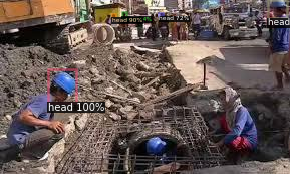

{'instances': Instances(num_instances=6, image_height=153, image_width=330, fields=[pred_boxes: Boxes(tensor([[ 88.4742,   7.0873, 127.0027,  52.1179],
        [117.5005,  21.9241, 168.8845,  79.4106],
        [242.9158,   0.4658, 312.1420,  82.2443],
        [  0.0000,   0.0000,  45.9589,  73.1772],
        [217.2578,  34.7622, 245.7133,  62.7783],
        [203.4609,  37.7095, 218.5880,  56.7630]], device='cuda:0')), scores: tensor([0.9968, 0.9959, 0.9955, 0.9784, 0.8694, 0.8447], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')])}


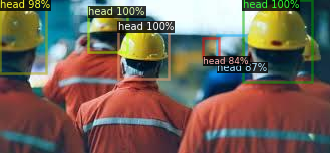

{'instances': Instances(num_instances=1, image_height=251, image_width=201, fields=[pred_boxes: Boxes(tensor([[ 66.2634,  63.9454, 147.2745, 166.6739]], device='cuda:0')), scores: tensor([0.9922], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


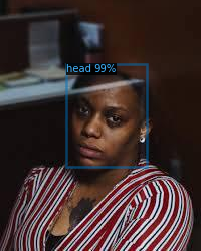

{'instances': Instances(num_instances=5, image_height=177, image_width=284, fields=[pred_boxes: Boxes(tensor([[225.8963,  19.6048, 244.5915,  39.4836],
        [166.6455,  13.3992, 183.9756,  34.0616],
        [ 84.9200,  89.7658, 101.5788, 109.6254],
        [112.7613,  73.6220, 129.3462,  92.5677],
        [ 46.1613,  96.1353,  86.8173, 149.1664]], device='cuda:0')), scores: tensor([0.9976, 0.9975, 0.9884, 0.9655, 0.9167], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0], device='cuda:0')])}


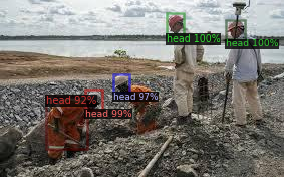

In [25]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_head_dicts(root_dir+"val", image_annotation_dict)
img_list = os.listdir(root_dir+"val")
for d in img_list[:10]:    
    # print(os.path.join(root_dir+"val", d))
    im = cv2.imread(os.path.join(root_dir+"val", d))
    # print(im)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=head_metadata,
                  #  scale=0.5 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs)
    # print(outputs["instances"])
    # break
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("head_val", ["bbox"], False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "head_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/27 08:55:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/27 08:55:49 d2.data.common]: Serializing 106 elements to byte tensors and concatenating them all ...
[04/27 08:55:49 d2.data.common]: Serialized dataset takes 0.03 MiB
[04/27 08:55:49 d2.evaluation.evaluator]: Start inference on 106 images
[04/27 08:55:50 d2.evaluation.evaluator]: Inference done 11/106. 0.1108 s / img. ETA=0:00:10
[04/27 08:55:55 d2.evaluation.evaluator]: Inference done 55/106. 0.1124 s / img. ETA=0:00:05
[04/27 08:56:01 d2.evaluation.evaluator]: Inference done 99/106. 0.1128 s / img. ETA=0:00:00
[04/27 08:56:01 d2.evaluation.evaluator]: Total inference time: 0:00:11.648976 (0.115336 s / img per device, on 1 devices)
[04/27 08:56:01 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.113110 s / img per device, on 1 devices)
[04/27 08:56:01 d2.evaluation.coco_evaluation]

# Mask and Helmet Classification Training

## Dataset Preparation

In [90]:
def get_bbox_list_from_annotations(annotation, key):
  return [list(map(str2float2int, [i["@xtl"],i["@ytl"],i["@xbr"],i["@ybr"]])) for i in annotation[key]["box"] if i["@label"] == "head" ]

# 'attribute': [{'#text': 'yes', '@name': 'has_safety_helmet'},
#     {'#text': 'yes', '@name': 'mask'}]}
helmet_idx2class = {1:"yes", 0:"no"}
helmet_class2idx = {"yes":1, "no":0}
mask_idx2class = {1:"yes", 0:"no", 2:"invisible"}
mask_class2idx = {"yes":1, "no":0, "invisible":2}

def list_of_boxes_labels(annotation, label_desc, label2idx):
  # set_trace()
  records = []
  record = {}
  for key in annotation.keys():
    # if key == "608":
    # set_trace()
    if type(annotation[key]["box"]) == dict:
      # set_trace()
      j = annotation[key]["box"]
      if j["@label"] == "head":
        record = {}
        record["fileid"] = key
        record["box"] =  list(map(str2float2int, [j["@xtl"],j["@ytl"],j["@xbr"],j["@ybr"]]))
        try:
          record["label"] = label2idx[[val["#text"] for val in j["attribute"] if val["@name"] == label_desc][0]]
        except KeyError as e:
          print(e)
          continue
        records.append(record)
    else:
      for i in annotation[key]["box"]:
        if i["@label"] == "head":
          record = {}
          record["fileid"] = key
          record["box"] =  list(map(str2float2int, [i["@xtl"],i["@ytl"],i["@xbr"],i["@ybr"]]))
          try:
            record["label"] = label2idx[[val["#text"] for val in i["attribute"] if val["@name"] == label_desc][0]]
          except KeyError as e:
            print(e)
            continue
          # set_trace()
          records.append(record)
  # set_trace()
  return records

class CustomHelmetDataset(Dataset):
    
    def __init__(self, img_dir, annotations, transform=None):
      self.img_dir = img_dir
      self.annotations = annotations
      self.transform = transform
    
    def __len__(self):
      return len(self.annotations)
    
    def __getitem__(self, idx):

      img_path = os.path.join(self.img_dir, self.annotations[idx]["fileid"]+".jpg")
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      x1,y1,x2,y2 = self.annotations[idx]["box"]
      img = img[y1:y2, x1:x2]
      # boxes = get_bbox_list_from_annotations(self.annotations, str(idx))
      # boxes = torch.as_tensor(boxes, dtype=torch.float32)
      label = self.annotations[idx]["label"]
      if self.transform:
        image = self.transform(image=img)["image"]
      # example = {"image": image, "label": label}
      return image, label

In [91]:
helmet_box_list = list_of_boxes_labels(image_annotation_dict, "has_safety_helmet", helmet_class2idx )
mask_box_list = list_of_boxes_labels(image_annotation_dict, "mask", mask_class2idx)

'wrong'


In [92]:
mask_box_list[3]

{'box': [490, 89, 495, 94], 'fileid': '2', 'label': 2}

## Train Helmet classifier

### Define Image Transformations


In [93]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor(),
    ]
)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensor()]
)


## Train and validate

In [94]:
def f1_score(truth, preds, multiclass):
  # set_trace()
  if multiclass:
    # print("multiclass is True")
    f1 = F1(num_classes=3, multiclass=multiclass)
    f1_score = f1(preds.int().cpu(), truth.int().cpu())
  else:
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
    f1 = F1(multiclass=multiclass)
    f1_score = f1(preds.int().cpu(), truth.int().cpu())
  return f1_score

def train(train_loader, model, criterion, optimizer, epoch, params, multiclass):
    # metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    total_f1 = 0.0
    total_loss = 0.0
    batches = 0
    # set_trace()
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        # set_trace()      
        output = model(images).squeeze(1)
        if multiclass:
          proba = torch.max(torch.softmax(output, dim=1),1).indices
          loss = criterion(output, target)
        else:
          proba = torch.sigmoid(output.to(params["device"]))
          # set_trace()
          target = target.type_as(output)
          loss = criterion(output, target)
        total_loss += loss
        f1 = f1_score(target, proba, multiclass)
        total_f1 += f1
        batches += 1
        # metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train Loss: {loss} F1: {F1}".format(epoch=epoch, loss=format(loss,".4f"), F1=format(f1,".4f")))
    return total_loss/batches, total_f1/batches

def validate(val_loader, model, criterion, epoch, params, multiclass):
    # metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    total_f1 = 0.0
    total_loss = 0.0
    batches = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            if multiclass:
              proba = torch.max(torch.softmax(output, dim=1),1).indices
              loss = criterion(output, target)
            else:
              proba = torch.sigmoid(output.to(params["device"]))
              target = target.type_as(output)
              loss = criterion(output, target)
            total_loss += loss
            f1 = f1_score(target, proba, multiclass)
            total_f1 += f1
            batches += 1
            # metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation Loss: {loss} F1: {F1}".format(epoch=epoch, loss=format(loss,".4f"), F1=format(f1, ".4f")))
    return total_loss/batches, total_f1/batches

def train_and_validate(model, train_dataset, val_dataset, criterion, optimizer, multiclass=False, model_postfix = ""):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    best_valid_f1 = 0.0
    # criterion = nn.BCEWithLogitsLoss()#.to(params["device"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        # print(type(train_loader))
        loss, f1 = train(train_loader, model, criterion, optimizer, epoch, params, multiclass)
        print("Train Loss avg: ",loss)
        print("Train F1 avg: ",f1)
        loss, f1 = validate(val_loader, model, criterion, epoch, params, multiclass)
        print("val Loss avg: ",loss)
        print("val F1 avg: ",f1)
        if f1 > best_valid_f1:
          best_valid_f1 = f1
          torch.save(model, root_dir+'model_best_valid_'+model_postfix+'.pth')
    return model

### Train Hemlet classification

In [95]:
train_helmet = helmet_box_list[:int(len(helmet_box_list) * 0.8)]
val_helmet =  helmet_box_list[int(len(helmet_box_list) * 0.8):]

train_helmet = CustomHelmetDataset(root_dir+'images', train_helmet, train_transform)
val_helmet = CustomHelmetDataset(root_dir+'images', val_helmet, val_transform)

params = {
    # "model": "UNet11",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 4,
    "num_workers": 1,
    "epochs": 5,
}



In [96]:

model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs,1)
model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
model = train_and_validate(model, train_helmet, val_helmet, criterion, optimizer, model_postfix = "helmet")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7



Train Loss avg:  tensor(0.5495, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.7469)



val Loss avg:  tensor(0.3884, device='cuda:0')
val F1 avg:  tensor(0.8212)



Train Loss avg:  tensor(0.4388, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.8317)



val Loss avg:  tensor(0.4082, device='cuda:0')
val F1 avg:  tensor(0.7762)



Train Loss avg:  tensor(0.3562, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.8666)



val Loss avg:  tensor(0.3516, device='cuda:0')
val F1 avg:  tensor(0.8141)



Train Loss avg:  tensor(0.3200, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.8858)



val Loss avg:  tensor(0.4202, device='cuda:0')
val F1 avg:  tensor(0.7441)



Train Loss avg:  tensor(0.2504, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.9128)



val Loss avg:  tensor(0.4258, device='cuda:0')
val F1 avg:  tensor(0.7470)


### Train Mask classification

In [97]:
train_mask = mask_box_list[:int(len(mask_box_list) * 0.8)]
val_mask =  mask_box_list[int(len(mask_box_list) * 0.8):]

train_mask = CustomHelmetDataset(root_dir+'images', train_mask, train_transform)
val_mask = CustomHelmetDataset(root_dir+'images', val_mask, val_transform)

params = {
    # "model": "UNet11",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 4,
    "num_workers": 1,
    "epochs": 5,
}


In [34]:
train_mask[30]

(tensor([[[-0.1657, -0.1657, -0.1486,  ..., -0.1314, -0.1314, -0.1314],
          [-0.1657, -0.1657, -0.1657,  ..., -0.1314, -0.1314, -0.1314],
          [-0.1657, -0.1657, -0.1657,  ..., -0.1143, -0.1143, -0.1314],
          ...,
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9705, -0.9363],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9534, -0.9363],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9705, -0.9363]],
 
         [[-0.2150, -0.2150, -0.1975,  ..., -0.0749, -0.0749, -0.0749],
          [-0.2325, -0.2150, -0.2150,  ..., -0.0749, -0.0749, -0.0749],
          [-0.2325, -0.2325, -0.2150,  ..., -0.0574, -0.0574, -0.0749],
          ...,
          [-1.3004, -1.3179, -1.3179,  ..., -1.0728, -1.0553, -1.0378],
          [-1.3004, -1.3004, -1.3004,  ..., -1.0553, -1.0553, -1.0378],
          [-1.3004, -1.3004, -1.3004,  ..., -1.0378, -1.0378, -1.0378]],
 
         [[-0.1487, -0.1487, -0.1487,  ...,  0.0779,  0.0779,  0.0779],
          [-0.1661, -0.1487,

In [98]:
model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs,3)
model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
model = train_and_validate(model, train_mask, val_mask, criterion, optimizer, multiclass=True, model_postfix="mask")

Loaded pretrained weights for efficientnet-b7



Train Loss avg:  tensor(0.8897, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.5901)



val Loss avg:  tensor(0.8240, device='cuda:0')
val F1 avg:  tensor(0.6870)



Train Loss avg:  tensor(0.7271, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.7032)



val Loss avg:  tensor(0.7525, device='cuda:0')
val F1 avg:  tensor(0.6824)



Train Loss avg:  tensor(0.6289, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.7591)



val Loss avg:  tensor(0.8890, device='cuda:0')
val F1 avg:  tensor(0.6398)



Train Loss avg:  tensor(0.5306, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.7940)



val Loss avg:  tensor(0.8087, device='cuda:0')
val F1 avg:  tensor(0.6824)



Train Loss avg:  tensor(0.4195, device='cuda:0', grad_fn=<DivBackward0>)
Train F1 avg:  tensor(0.8422)



val Loss avg:  tensor(0.9521, device='cuda:0')
val F1 avg:  tensor(0.6231)


# Check predictions

In [99]:
helmet_model = torch.load(root_dir+'model_best_valid_helmet.pth')
helmet_model.eval()
mask_model = torch.load(root_dir+'model_best_valid_mask.pth')
mask_model.eval()
# output_dir = "drive/MyDrive/interview/task2/output"
# head_model = torch.load(output_dir+"model_final.pth")

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [100]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

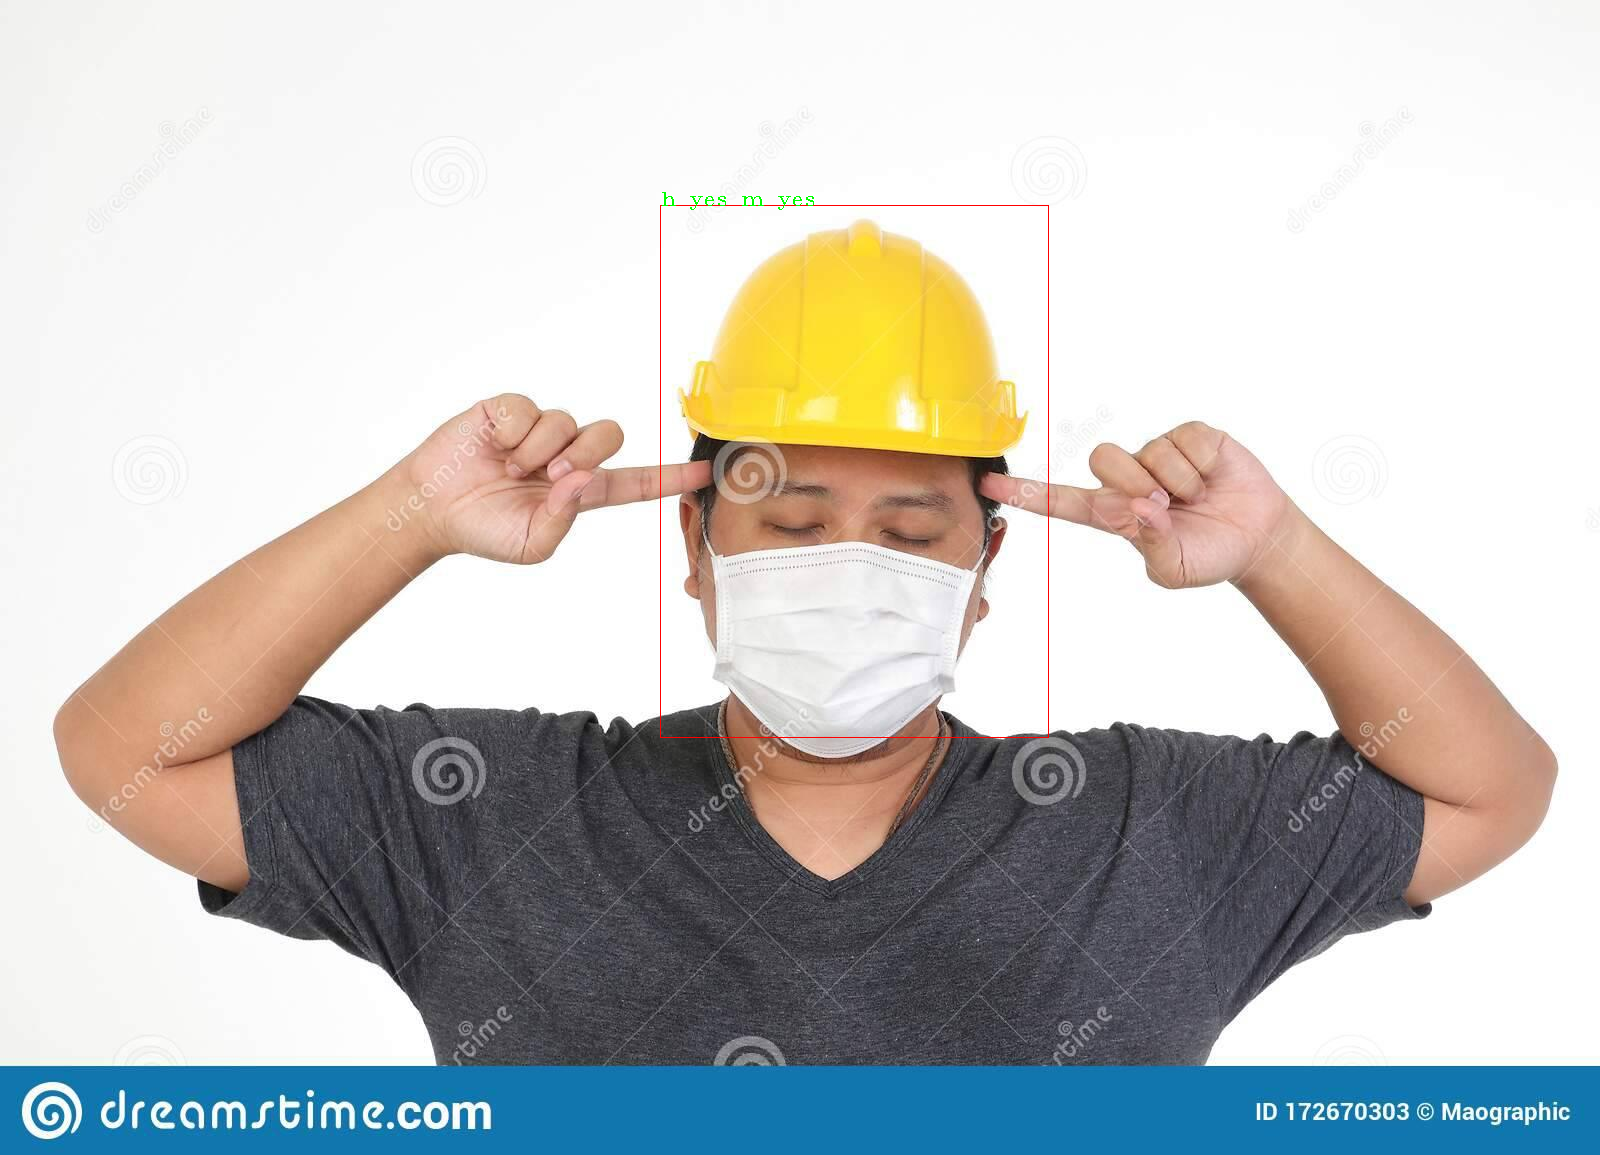

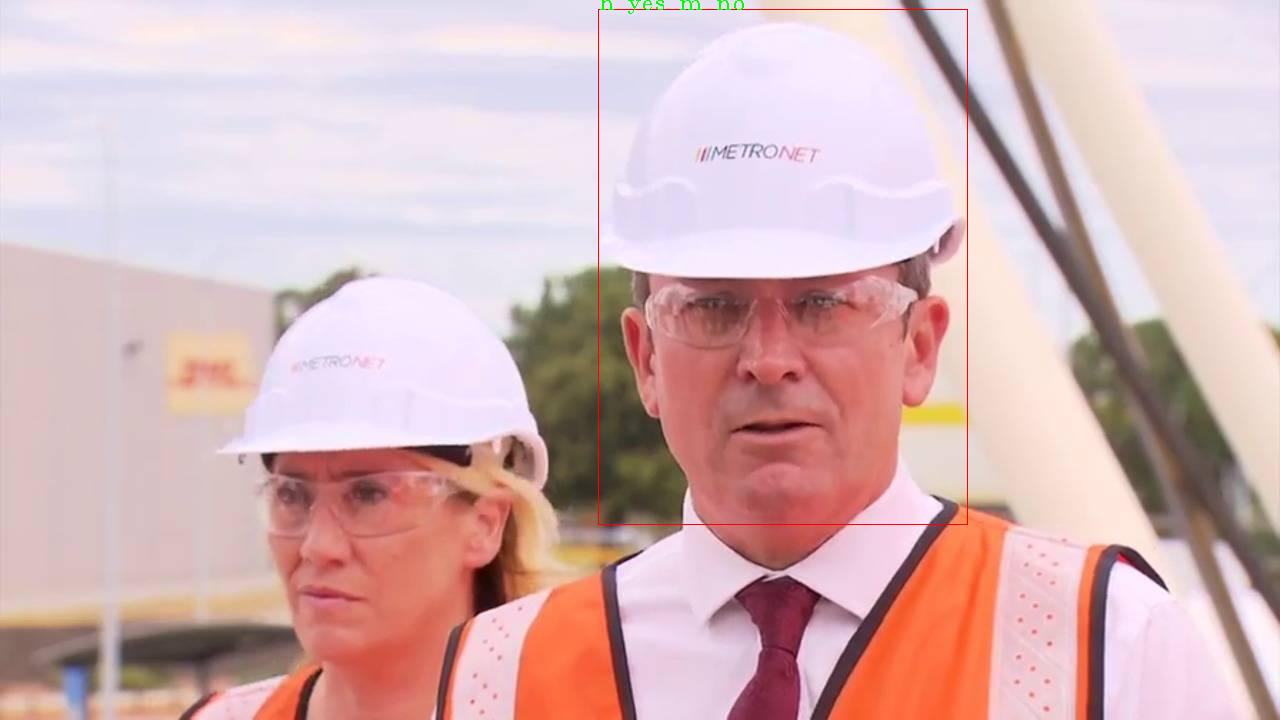

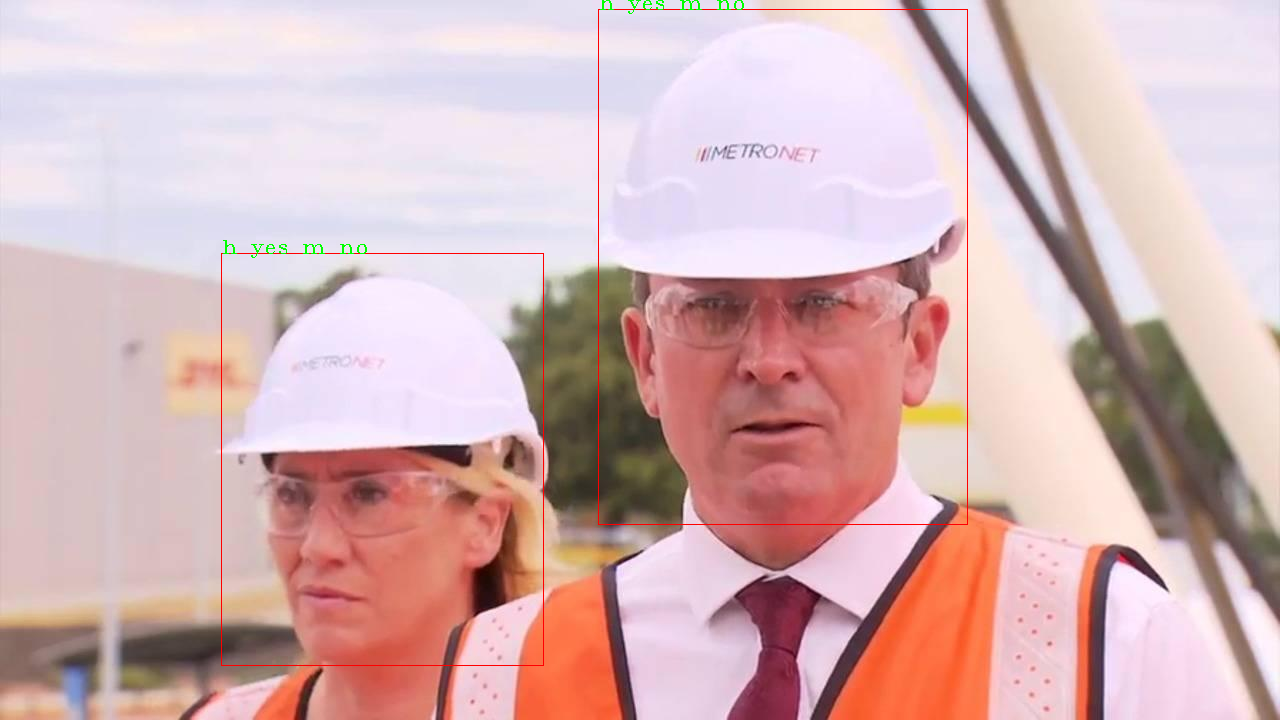

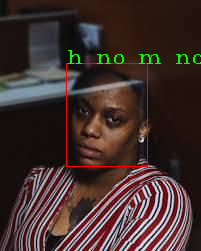

In [102]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
# dataset_dicts = get_head_dicts(root_dir+"val", image_annotation_dict)

font                   = cv2.FONT_HERSHEY_COMPLEX_SMALL
# bottomLeftCornerOfText = (10,500)
fontScale              = 1
fontColor              = (0,255,0)
lineType               = 1

img_list = os.listdir(root_dir+"test")
img_list = ["44.jpg", "64.jpg", "308.jpg"]
for d in img_list:    
    # print(os.path.join(root_dir+"val", d))
    im = cv2.imread(os.path.join(root_dir+"images", d))
    # print(im)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # print(outputs["instances"].pred_boxes)
    for box in outputs["instances"].pred_boxes:
      x1,y1,x2,y2 = box
      im_temp = im[int(y1):int(y2), int(x1):int(x2)]
      im_temp1 = val_transform(image=im_temp)["image"]
      # set_trace()
      preds = helmet_model(im_temp1.unsqueeze(0).cuda())
      preds = torch.sigmoid(preds)
      preds = preds.cpu()
      preds[preds > 0.5] = 1
      preds[preds < 0.5] = 0
      helmet_text = "h "+helmet_idx2class[preds[0][0].item()]

      im_temp2 = val_transform(image=im_temp)["image"]
      # set_trace()
      preds = mask_model(im_temp2.unsqueeze(0).cuda())
      preds = torch.max(torch.softmax(preds, dim=1),1).indices
      preds = preds.cpu()
      # preds[preds > 0.5] = 1
      mask_text = "m "+mask_idx2class[preds[0].item()]
      
      red = (0,0,255)
      cv2.rectangle(im, (x1, y1), (x2, y2), red)
      cv2.putText(im,helmet_text+" "+mask_text,
                  (x1,y1), 
                  font, 
                  fontScale,
                  fontColor,
                  lineType)
      # print(im_temp)
      # plt.imshow(im)
      cv2_imshow(im)
      # cv2_imshow(im_temp)